In [1]:
import numpy as np
import pandas as pd

import cv2
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [2]:
torch.__version__, torchvision.__version__

('1.13.1+cu116', '0.14.1+cu116')

## Model

In [3]:
def double_convs(in_channels, out_channels):
    conv_layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same', bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),

        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same', bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

    return conv_layers

def expansion_block(upsample_layer, conv_layer, inp, concat_inp):
    mask = upsample_layer(inp)
    mask = torch.concat([concat_inp, mask], dim=1)
    mask = conv_layer(mask)

    return mask


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super().__init__()

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        #contraction path
        self.contrac1 = double_convs(in_channels, 64)
        self.contrac2 = double_convs(64, 128)
        self.contrac3 = double_convs(128, 256)
        self.contrac4 = double_convs(256, 512)
        self.contrac5 = double_convs(512, 1024)

        #expansion path
        self.upsample1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.double_conv1 = double_convs(1024, 512)
        self.upsample2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.double_conv2 = double_convs(512, 256)
        self.upsample3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.double_conv3 = double_convs(256, 128)
        self.upsample4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.double_conv4 = double_convs(128, 64)

        #output layer
        self.out = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.Conv2d(64, out_channels, kernel_size=1)
            )

    def forward(self, image):
        #contraction
        cntrc_out1 = self.contrac1(image) #->
        out1 = self.max_pool(cntrc_out1)
        
        cntrc_out2 = self.contrac2(out1) #->
        out2 = self.max_pool(cntrc_out2)

        cntrc_out3 = self.contrac3(out2) #->
        out3 = self.max_pool(cntrc_out3)

        cntrc_out4 = self.contrac4(out3) #->
        out4 = self.max_pool(cntrc_out4)

        cntrc_out5 = self.contrac5(out4)

        #expansion
        mask = expansion_block(self.upsample1, self.double_conv1, cntrc_out5, cntrc_out4)
        mask = expansion_block(self.upsample2, self.double_conv2, mask, cntrc_out3)
        mask = expansion_block(self.upsample3, self.double_conv3, mask, cntrc_out2)
        mask = expansion_block(self.upsample4, self.double_conv4, mask, cntrc_out1)

        #output
        output = self.out(mask)

        return output

In [4]:
model = UNet(3, 22)

In [5]:
checkpoint = torch.load("../model/model.pt", map_location="cpu")
model_state = checkpoint['model_state_dict']

In [6]:
model.load_state_dict(model_state)

<All keys matched successfully>

## Loading Data

In [7]:
def transform_inputs(image_path, mask_path):
    transforms = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
    ])

    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    trnsfrmd = transforms(image=image, mask=mask)

    image = trnsfrmd['image']
    mask = trnsfrmd['mask']
    
    return (image, mask)

In [8]:
def get_output(model, image):
    image = image.unsqueeze(0)
    
    logits = model(image.float())
    probs = logits.softmax(axis=1)
    probs = probs[0]
    pred = torch.argmax(probs, axis=0)
    pred *= 10
    pred_image = T.ToPILImage()(pred.float())
    
    return pred, pred_image

In [9]:
idx = 1

In [10]:
data = pd.read_csv('../dataset/preprocessed_data.csv')
mask_path = data.loc[idx, 'mask']
img_path = data.loc[idx, 'images']

In [11]:
image, mask = transform_inputs(img_path, mask_path)

In [12]:
pred_tnsr, pred = get_output(model, image)

## PREDICTED MASK

In [13]:
type(image.numpy())

numpy.ndarray

In [14]:
np_image = image.permute(1,2,0).numpy()
np_image.shape

(256, 256, 3)

In [15]:
np_mask = mask.numpy()
np_mask.shape

(256, 256)

In [16]:
np_pred = pred_tnsr.numpy()
np_pred.shape

(256, 256)

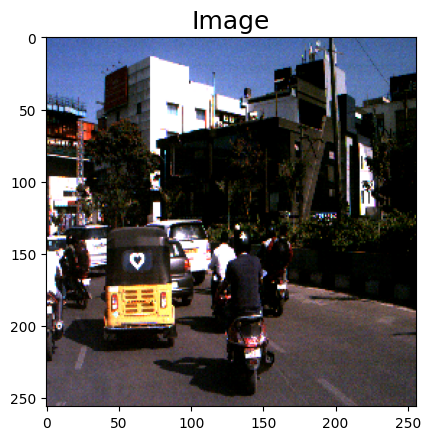

In [17]:
plt.title("Image",fontdict={'fontsize':18})
plt.imshow(np_image)
plt.show()

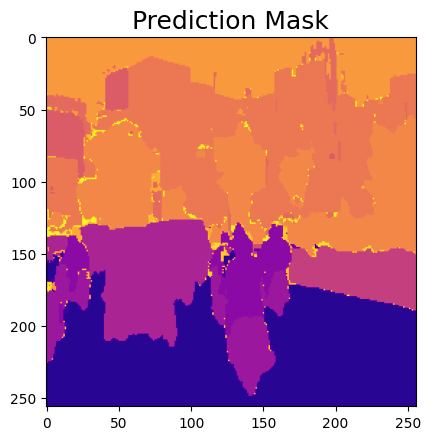

In [18]:
plt.title("Prediction Mask",fontdict={'fontsize':18})
rgb_np = plt.imshow(np_pred, cmap='plasma')
plt.show()

In [19]:
cm = plt.get_cmap('plasma')
colored_image = cm(np_pred)

In [20]:
type(colored_image)

numpy.ndarray

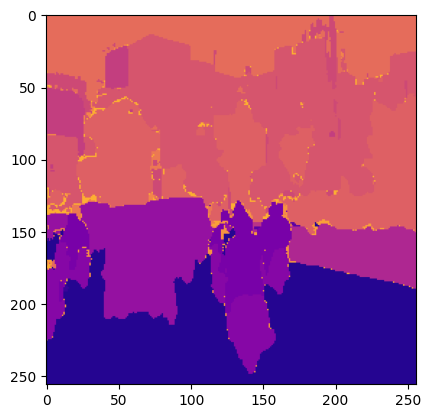

In [21]:
plt.imshow(colored_image)
plt.show()

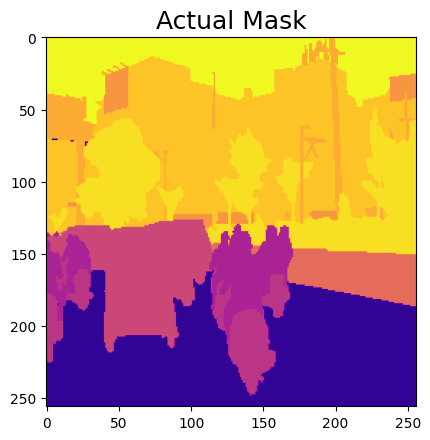

In [22]:
plt.title("Actual Mask",fontdict={'fontsize':18})
plt.imshow(np_mask, cmap='plasma')
plt.show()

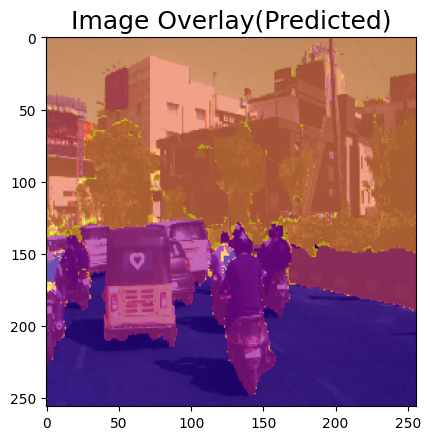

In [23]:
plt.title("Image Overlay(Predicted)",fontdict={'fontsize':18})
plt.imshow(np_image)
plt.imshow(np_pred, cmap='plasma', alpha=0.7)
plt.show()

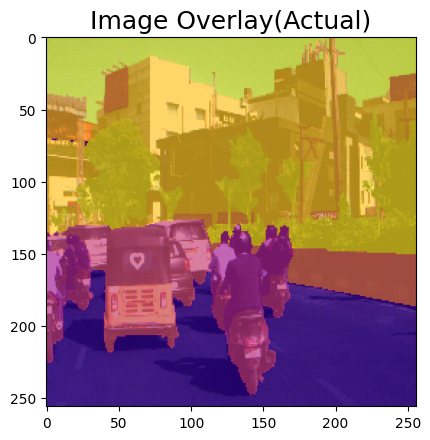

In [24]:
plt.title("Image Overlay(Actual)",fontdict={'fontsize':18})
plt.imshow(np_image)
plt.imshow(np_mask, cmap='plasma', alpha=0.7)
plt.show()

In [25]:
from matplotlib import cm

In [26]:
n_colors = 22
colours = cm.inferno(np.random.uniform(size = n_colors))

In [27]:
colours

array([[0.658463, 0.178962, 0.372748, 1.      ],
       [0.428768, 0.09479 , 0.432412, 1.      ],
       [0.615513, 0.161817, 0.391219, 1.      ],
       [0.846709, 0.297559, 0.244113, 1.      ],
       [0.447428, 0.101597, 0.43108 , 1.      ],
       [0.50973 , 0.123769, 0.422156, 1.      ],
       [0.002267, 0.00127 , 0.01857 , 1.      ],
       [0.980824, 0.572209, 0.028508, 1.      ],
       [0.64626 , 0.173914, 0.378359, 1.      ],
       [0.964394, 0.843848, 0.273391, 1.      ],
       [0.190367, 0.039309, 0.361447, 1.      ],
       [0.949545, 0.955063, 0.50786 , 1.      ],
       [0.60933 , 0.159474, 0.393589, 1.      ],
       [0.522206, 0.12815 , 0.419549, 1.      ],
       [0.087411, 0.044556, 0.224813, 1.      ],
       [0.013995, 0.011225, 0.071862, 1.      ],
       [0.004547, 0.003392, 0.030909, 1.      ],
       [0.453651, 0.103848, 0.430498, 1.      ],
       [0.962517, 0.851476, 0.285546, 1.      ],
       [0.379001, 0.076253, 0.432719, 1.      ],
       [0.553392, 0.

In [28]:
from skimage import color
result_image = color.label2rgb(np_mask, np_image, colors=colours, alpha=0.5)

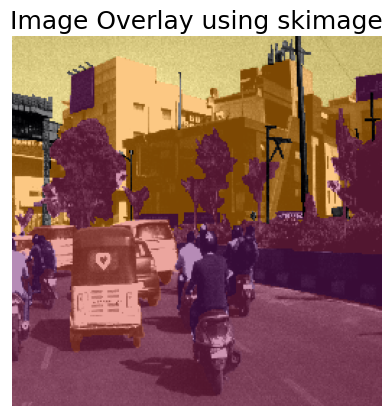

In [29]:
plt.title("Image Overlay using skimage", fontdict={'fontsize':18})
plt.imshow(result_image)
plt.axis('off')
plt.show()

In [30]:
colours

array([[0.658463, 0.178962, 0.372748, 1.      ],
       [0.428768, 0.09479 , 0.432412, 1.      ],
       [0.615513, 0.161817, 0.391219, 1.      ],
       [0.846709, 0.297559, 0.244113, 1.      ],
       [0.447428, 0.101597, 0.43108 , 1.      ],
       [0.50973 , 0.123769, 0.422156, 1.      ],
       [0.002267, 0.00127 , 0.01857 , 1.      ],
       [0.980824, 0.572209, 0.028508, 1.      ],
       [0.64626 , 0.173914, 0.378359, 1.      ],
       [0.964394, 0.843848, 0.273391, 1.      ],
       [0.190367, 0.039309, 0.361447, 1.      ],
       [0.949545, 0.955063, 0.50786 , 1.      ],
       [0.60933 , 0.159474, 0.393589, 1.      ],
       [0.522206, 0.12815 , 0.419549, 1.      ],
       [0.087411, 0.044556, 0.224813, 1.      ],
       [0.013995, 0.011225, 0.071862, 1.      ],
       [0.004547, 0.003392, 0.030909, 1.      ],
       [0.453651, 0.103848, 0.430498, 1.      ],
       [0.962517, 0.851476, 0.285546, 1.      ],
       [0.379001, 0.076253, 0.432719, 1.      ],
       [0.553392, 0.

In [31]:
result_image = color.label2rgb(np_pred, np_image, colors=colours, alpha=0.8)

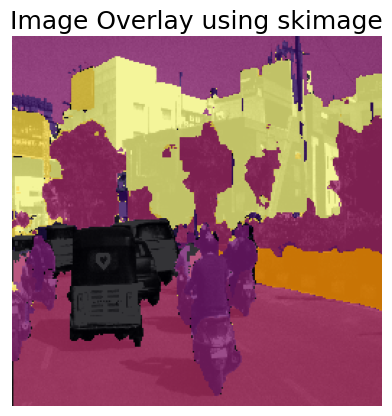

In [32]:
plt.title("Image Overlay using skimage", fontdict={'fontsize':18})
plt.imshow(result_image)
plt.axis('off')
plt.show()

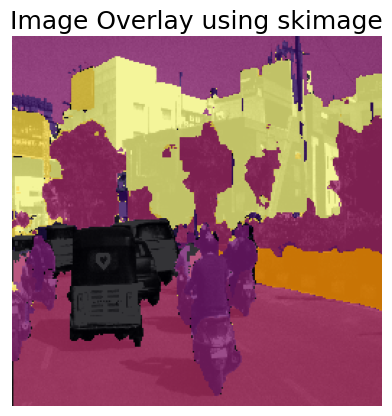

In [33]:
plt.title("Image Overlay using skimage", fontdict={'fontsize':18})
plt.imshow(result_image)
plt.axis('off')
plt.show()

In [34]:
result_image.shape

(256, 256, 3)

In [35]:
result_image.max(), result_image.min()

(0.9715152, 0.0010160000000000002)

In [36]:
result_image.dtype==np.float64

True

In [37]:
import io
import base64

In [38]:
def encode_arr(np_img):
    img = Image.fromarray((np_img*255).astype(np.uint8), 'RGB')
    buffered = io.BytesIO()
    img.save(buffered, format="JPEG")
    img_bytes = base64.b64encode(buffered.getvalue())

    img_string = img_bytes.decode()
    
    return img_string

In [39]:
def decode_data(encd_str):
    img = Image.open(io.BytesIO(base64.decodebytes(bytes(encd_str, "utf-8"))))
    
    np_arr = np.array(img)
    
    return np_arr   

In [40]:
img_str = encode_arr(result_image)

In [41]:
img_arr = decode_data(img_str)

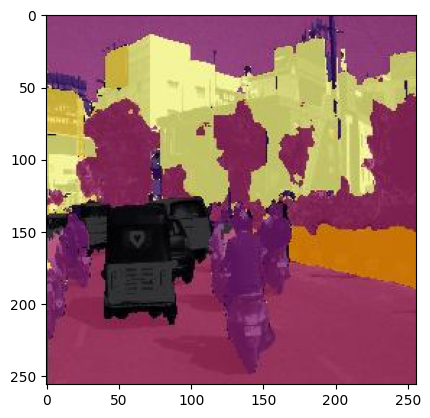

In [42]:
plt.imshow(img_arr)